In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np
from scipy.stats import norm
import warnings
import matplotlib.pyplot as plt
from math import sqrt
import time
from statistics import stdev
from datetime import date, timedelta, datetime
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint
from scipy.stats import skew
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

---
#Data
---

In [ ]:
def get_data(csv_path, start_date, end_date):

    df = pd.read_excel(csv_path)
    df_prices = pd.DataFrame()
    start_date = datetime.strptime(start_date, '%d/%m/%Y').strftime('%Y-%m-%d')
    end_date = datetime.strptime(end_date, '%d/%m/%Y').strftime('%Y-%m-%d')

    for index, row in df.iterrows():
        ticker = row['Stock Ticker']
        stock_name = row['Stock Name']
        if end_date :
          data = yf.download(ticker, start=start_date, end = end_date, progress=False)
        else:
          data = yf.download(ticker, start=start_date, progress=False)
        df_prices[stock_name] = data['Close']

    df_returns = df_prices.pct_change()
    df_returns = df_returns.drop(df_returns.index[0])

    return df_prices, df_returns

In [ ]:
def get_cac40_data(start_date, end_date=None):

    df_yf = pd.DataFrame()
    start_date = datetime.strptime(start_date, '%d/%m/%Y').strftime('%Y-%m-%d')
    if end_date:
        end_date = datetime.strptime(end_date, '%d/%m/%Y').strftime('%Y-%m-%d')

    #
    cac40_symbol = "^FCHI"

    if end_date:
        cac40_data = yf.download(cac40_symbol, start=start_date, end=end_date, progress=False)
    else:
        cac40_data = yf.download(cac40_symbol, start=start_date, progress=False)

    df_yf["CAC40"] = cac40_data['Close']

    df_returns = df_yf.pct_change()
    df_returns = df_returns.drop(df_returns.index[0])

    return df_returns

---
#Kernel density
---


In [ ]:
def silverman_bandwidth(data):
    sigma = stdev(data)
    n = len(data)
    iqr = np.percentile(data, 75) - np.percentile(data, 25)
    bandwidth = 0.9 * np.minimum(sigma, iqr/1.34) * n**(-0.2)
    return bandwidth

In [ ]:
def scott_bandwidth(data):
    n = len(data)
    sigma = np.std(data)
    bandwidth = 1.06 * sigma * n**(-0.2)
    return bandwidth

In [ ]:
def kernel_density_estimate(data, x, bandwidth):
    kernel_vals = norm.pdf(((x - data) / bandwidth))
    return np.sum(kernel_vals) / (len(data) * bandwidth)

In [ ]:
def recursive_dynamic_kernel(data, x, bandwidth, w = 0.98, t0 = 50):
    t = len(data)
    weight = ((1 - w) * w ** (t - t0)) / (1 - w ** t0)
    kernel_vals = weight * norm.pdf(((x - data[t0]) / bandwidth)) / bandwidth
    for i in range(t0+1,t):
      kernel_vals = w * kernel_vals + ((1 - w) / bandwidth) * norm.pdf(((x - data[i]) / bandwidth))
    return kernel_vals

In [ ]:
def calculate_skew(returns, h):
  r3, r2 = 0, 0
  for i in range(len(returns)):
    r3 += returns.iloc[i]**3
    r2 += returns.iloc[i]**2
  r3 = r3/len(returns)
  r2 = r2/len(returns)
  mu = np.mean(returns)
  skewness=0
  if np.isfinite((np.std(returns)**2 + h**2)**(3/2)):
    skewness = (r3 + np.mean(returns)* (h**2) * 3 - mu**3 -3*mu*(r2 + h**2) +3*mu**3)/(np.std(returns)**2 + h**2)**(3/2)
  else:
    skewness = 0
  return skewness

In [ ]:
def calculate_vol(returns, h):
  return np.std(returns)**2 + h**2

---
#Portfolio optimisation
---

In [ ]:
def utility_function_ridge(rdts, vols, weights, prev_weights, ridge_alpha, risk_aversion, condition):

    portfolio_returns = np.dot(rdts, weights)
    portfolio_volatility = np.sqrt(np.dot(np.array(weights)**2, np.array(vols)**2))
    if condition :
      ridge_penalty = ridge_alpha * np.sum((weights - prev_weights)**2)
    else :
      ridge_penalty = 0

    return np.mean(portfolio_returns) - risk_aversion * portfolio_volatility - ridge_penalty

In [ ]:
def optimize_ridge(df, ridge_coef, prev_weights, risk_aversion, condition = True):

    rdts = df['Average daily return (%)']
    vols = df['Daily Volatility (%)']
    names = df['Stock']

    def objective(weights):
        return -utility_function_ridge(rdts, vols, weights, prev_weights, ridge_coef, risk_aversion, condition)

    n = len(rdts)
    initial_weights = np.ones(n) / n  # Valeurs initiales des poids

    bounds = [(0, 1) for _ in range(n)]  # Bornes des poids (entre 0 et 1)
    linear_constraint = LinearConstraint(np.ones(n), 1, 1)  # Contrainte de somme égale à 1

    result = minimize(objective, initial_weights, bounds=bounds, constraints=linear_constraint, method='SLSQP')

    optimal_weights = result.x

    return list(zip(names, optimal_weights))

---
#Tools
---

In [ ]:
def window_format(window_length):
  end = datetime.today().date()
  start = end - timedelta(days=window_length)

  end = end.strftime("%d/%m/%Y")
  start = start.strftime("%d/%m/%Y")

  return start, end

In [ ]:
def column_means(df):
    means = {}
    for column in df.columns:
        means[column] = df[column].mean()
    return means

---
#Metrics
---

In [ ]:
def CAGR(prices):
  T = len(prices)
  return (prices[-1]/prices[0])**(252/T) - 1

In [ ]:
def annualized_vol(returns):
    volatility = np.std(returns) * np.sqrt(252)
    return volatility

In [ ]:
def sharpe_ratio(perf, vol, rate = 0):
    return (perf - rate)/vol

In [ ]:
def max_drawdown(returns):
    cumulative_returns = np.cumsum(returns)
    previous_peaks = np.maximum.accumulate(cumulative_returns)
    drawdowns = cumulative_returns - previous_peaks
    max_drawdown = np.min(drawdowns)
    return max_drawdown

---
#Strategies
---

In [ ]:
def strat_equi(initial_weights, prices):
  return initial_weights

In [ ]:
def strategy_skew(prices, nb_asset_selected, h_method, train_len):
  nb_asset = len(prices.columns)
  skews = []

  for i in range(nb_asset):
      rdt = prices.iloc[:, i][-train_len:].pct_change().dropna()

      if h_method == 'Scott':
        h_opti = scott_bandwidth(rdt)
      elif h_method == 'Silver':
        h_opti = silverman_bandwidth(rdt)

      skewness = calculate_skew(rdt, h_opti)
      skews.append(skewness)

  skews_sorted = sorted(skews)
  skews_sorted = skews_sorted[0:nb_asset_selected]
  indices = [int(skews.index(value)) for value in skews_sorted]
  optimal_weights = [0] * nb_asset
  for i in range(nb_asset):
    if i in indices:
      optimal_weights[i] = (1/nb_asset_selected)
  return optimal_weights

In [ ]:
def strategy_sharpe(prices, nb_asset_selected, h_method, train_len):
  nb_asset = len(prices.columns)
  sharpes = []

  for i in range(nb_asset):
      rdt = prices.iloc[:, i][-train_len:].pct_change().dropna()

      if h_method == 'Scott':
        h_opti = scott_bandwidth(rdt)
      elif h_method == 'Silver':
        h_opti = silverman_bandwidth(rdt)

      vol = calculate_vol(rdt, h_opti)
      mu = np.mean(rdt)
      sharpe = mu/vol
      sharpes.append(sharpe)

  sharpes_sorted = sorted(sharpes, reverse=True)
  sharpes_sorted = sharpes_sorted[0:nb_asset_selected]
  indices = [int(sharpes.index(value)) for value in sharpes_sorted]
  optimal_weights = [0] * nb_asset
  for i in range(nb_asset):
    if i in indices:
      optimal_weights[i] = (1/nb_asset_selected)
  return optimal_weights

In [ ]:
def strategy_rdt(prices, nb_asset_selected, h_method, train_len):
  nb_asset = len(prices.columns)
  returns = []

  for i in range(nb_asset):
      rdt = prices.iloc[:, i][-train_len:].pct_change().dropna()

      if h_method == 'Scott':
        h_opti = scott_bandwidth(rdt)
      elif h_method == 'Silver':
        h_opti = silverman_bandwidth(rdt)

      returns.append(np.mean(rdt))

  returns_sorted = sorted(returns)
  returns_sorted = returns_sorted[0:nb_asset_selected]
  indices = [int(returns.index(value)) for value in returns_sorted]
  optimal_weights = [0] * nb_asset
  for i in range(nb_asset):
    if i in indices:
      optimal_weights[i] = (1/nb_asset_selected)
  return optimal_weights

In [ ]:
def strategy_rdt_vol(prices, nb_asset_selected, h_method, train_len):
  nb_asset = len(prices.columns)
  returns = []

  for i in range(nb_asset):
      rdt = prices.iloc[:, i][-train_len:].pct_change().dropna()

      if h_method == 'Scott':
        h_opti = scott_bandwidth(rdt)
      elif h_method == 'Silver':
        h_opti = silverman_bandwidth(rdt)
      vol = calculate_vol(rdt, h_opti)
      returns.append(np.mean(rdt)-vol/2)

  returns_sorted = sorted(returns)
  returns_sorted = returns_sorted[0:nb_asset_selected]
  indices = [int(returns.index(value)) for value in returns_sorted]
  optimal_weights = [0] * nb_asset
  for i in range(nb_asset):
    if i in indices:
      optimal_weights[i] = (1/nb_asset_selected)
  return optimal_weights

---
#Backtest
---

## **Backtest tools**

- Portfolio returns : calculate the daily portfolio returns on the window starting from the end to backtest_length

- Portfolio valorisation : value the portfolio from an initial investment and the portfolio returns. Also valorise a benchmark (CAC40) portfolio with the same initial investment

In [ ]:
def data_for_backtest(start_date, end_date, train_length):

  backtest_prices, _ = get_data("univers_actions.xlsx", start_date, end_date)
  train_length = int(train_length * (7/5))
  date_train = datetime.strptime(start_date, '%d/%m/%Y') - timedelta(days=train_length)
  date_train = date_train.strftime('%d/%m/%Y')
  train_prices, _ = get_data("univers_actions.xlsx", date_train, start_date)

  return backtest_prices, train_prices

In [ ]:
def ptf_returns(weights, prices, backtest_length):
    portfolio_returns = []
    prices = prices[-backtest_length:]
    portfolio_returns.append(0.0)
    for i in range(1, backtest_length):
        rdt = ((prices.iloc[i]-prices.iloc[i-1])/prices.iloc[i-1]).values
        daily_returns = np.dot(weights[i - 1], rdt)
        portfolio_returns.append(daily_returns)
    return portfolio_returns

In [ ]:
def valo_cac40(initial_amount, start_date, end_date, backtest_length):

  cac40_returns = get_cac40_data(start_date, end_date)
  cac40_last = pd.Series([cac40_returns['CAC40'][-1]], name='CAC40')
  cac40_returns = cac40_returns._append(cac40_last)
  cac40_returns = cac40_returns[-backtest_length:]
  ptf_cac40 = [initial_amount]

  for i in range(1, len(cac40_returns)):
    ptf_cac40.append(ptf_cac40[i-1] * (1 + cac40_returns['CAC40'].iloc[i]))

  ptf_cac40[-1] = ptf_cac40[-2] + (ptf_cac40[-2]-ptf_cac40[-3])

  return ptf_cac40

In [ ]:
def ptf_valo(ptf_returns, initial_amount, start_date, end_date, backtest_length):

  cac40_returns = get_cac40_data(start_date, end_date)

  cac40_last = pd.Series([cac40_returns['CAC40'][-1]], name='CAC40')
  cac40_returns = cac40_returns._append(cac40_last)

  cac40_returns = cac40_returns[-backtest_length:]
  ptf_valo = [initial_amount]
  ptf_cac40 = [initial_amount]

  for i in range(1, len(ptf_returns)):
    ptf_valo.append(ptf_valo[i-1] * (1 + ptf_returns[i]))
    ptf_cac40.append(ptf_cac40[i-1] * (1 + cac40_returns['CAC40'].iloc[i]))
  ptf_cac40[-1] = ptf_cac40[-2] + (ptf_cac40[-2]-ptf_cac40[-3])

  return ptf_valo, ptf_cac40

In [ ]:
def valo_inter(ptf_returns, initial_amount, start_date, end_date, backtest_length):

  ptf_valo = [initial_amount]

  for i in range(1, len(ptf_returns)):
    ptf_valo.append(ptf_valo[i-1] * (1 + ptf_returns[i]))

  return ptf_valo

In [ ]:
def plot_allocation(dates, weights, ax, label_strat):

  weights_plot = []

  for i in range(len(weights[0])):
    asset_weights = []
    for j in range(len(weights)):
      asset_weights.append(weights[j][i])
    weights_plot.append(asset_weights)

  ax.stackplot(dates, *weights_plot)
  ax.set_title(f"Allocation {label_strat}")
  ax.set_xlim(dates.min(), dates.max())
  ax.set_ylim(0, 1)

In [ ]:
def ptf_stats_yearly(ptf_prices, benchmark_prices, dates, strat_name):

  years = list(set([date.year for date in dates]))

  stats = pd.DataFrame(columns=["Annualized Return", "Annualized Volatility", "Sharpe", "Max Draw-Down"],
                       index=pd.MultiIndex.from_product([years, [str(strat_name),"CAC40"]]))

  for year in years:

    ptf_annual_prices = []
    bm_annual_prices = []

    for i,date in enumerate(dates):
      if date.year == year:
        ptf_annual_prices.append(ptf_prices[i])
        bm_annual_prices.append(benchmark_prices[i])

    ptf_returns = pd.Series(ptf_annual_prices).pct_change()[1:]
    bm_returns = pd.Series(bm_annual_prices).pct_change()[1:]

    ptf_annualized_return = round(CAGR(ptf_annual_prices)* 100,2)
    bm_annualized_return = round(CAGR(bm_annual_prices)* 100,2)

    ptf_annualized_volatility = round(annualized_vol(ptf_returns)* 100,2)
    bm_annualized_volatility = round(annualized_vol(bm_returns)* 100,2)

    ptf_sharpe = round(sharpe_ratio(ptf_annualized_return, ptf_annualized_volatility),2)
    bm_sharpe = round(sharpe_ratio(bm_annualized_return, bm_annualized_volatility),2)

    ptf_MDD = round(max_drawdown(ptf_returns)* 100,2)
    bm_MDD = round(max_drawdown(bm_returns)* 100,2)

    stats.loc[(year, str(strat_name))] = [ptf_annualized_return, ptf_annualized_volatility, ptf_sharpe, ptf_MDD]
    stats.loc[(year, "CAC40")] = [bm_annualized_return, bm_annualized_volatility, bm_sharpe, bm_MDD]

  return stats

##Backtest code vieux

In [ ]:
def backtest_strategy_vieux(start_date, end_date, initial_investment, initial_weights, train_length, strat, fees = True, tc_fees=0.001):
  #Get the prices over the backtest window for every asset
  backtest_prices, _ = get_data("univers_actions.xlsx", start_date, end_date)
  #print(backtest_prices)
  #Conversion from real day interval to market day interval
  train_length = int(train_length * (7/5))
  #Get the prices for the initial train window
  date_train = datetime.strptime(start_date, '%d/%m/%Y')
  date_train -= timedelta(days=train_length)
  date_train = date_train.strftime('%d/%m/%Y')
  train_prices, _ = get_data("univers_actions.xlsx", date_train, start_date)

  #Initialisation of weights list and length for the backtest iterations
  weights = []
  #weights = weights.append()
  weights = [initial_weights]
  nb_asset = len(backtest_prices.columns)
  backtest_length = len(backtest_prices)
  total_tc_costs = 0
  tc_costs = 0
  #print(f'longeur backtest : {backtest_length}')
  #Repeat for every day of the backtest window
  for t in range(backtest_length):
    #Get the portofolio allocation from the strategy
    current_portfolio = strat(train_prices)
    #print(f"Stratégie : {strat.__name__}")
    #print(current_portfolio)
    #weights.append(strat(initial_weights, train_prices, nb_worst_rdt))
    train_prices = train_prices.drop(train_prices.index[0])
    price_t = backtest_prices.iloc[t]
    train_prices = train_prices._append(price_t, ignore_index=True)

    if fees == True:
      if t > 0:
          tc_costs = sum(abs(current_portfolio[i] - weights[-1][i]) * price_t[i] * tc_fees for i in range(nb_asset))
          total_tc_costs += tc_costs
          price_t -= tc_costs

        # Calculate the potential change in portfolio value
      potential_portfolio_value = sum(current_portfolio[i] * price_t[i] for i in range(nb_asset))
      last_portfolio_value = sum(weights[-1][i] * price_t[i] for i in range(nb_asset))
      potential_gain = potential_portfolio_value - last_portfolio_value
      # Check if the potential gain is greater than transaction costs
      '''
      if potential_gain >= tc_costs:
          weights.append(current_portfolio)  # Only update weights if the change is worth it
      else: # If not worth it, keep the last weights
          weights.append(weights[-1])
      '''
      weights.append(current_portfolio)
    else :
      weights.append(current_portfolio)

  del weights[0]
  #Get the date corresponding to the backtest window
  dates = backtest_prices.index[-backtest_length:]
  #Calculate the return of the portfolio
  ptf_rdt = ptf_returns(weights, backtest_prices, backtest_length)
  #Value the custom portfolio and the benchmark portfolio at each time of the backtest window
  ptf, ptf_cac40 = ptf_valo(ptf_rdt, initial_investment, start_date, end_date, backtest_length)
  #df = pd.DataFrame({'Portfolio': ptf, 'CAC40': ptf_cac40})
  #Get statistics from the portfolios
  #stats = ptf_stats(ptf,ptf_cac40)
  strat_name = strat.__name__
  stats = ptf_stats_yearly(ptf, ptf_cac40, dates, strat_name)
  #stats.index = [str(strat.__name__), 'CAC40']
  print(f'total tc : {total_tc_costs}')
  print(ptf)
  return dates, ptf, ptf_cac40, stats, weights

##Backtest code

Step for backtest :

Get data for the backtest :
    - backtest_prices = prices of the stocks over the backtest period
    - train_prices = prices of ther stocks over the train window before the backtest period

Initialisation :
    - weights = portfolio allocations over the backtest
    - nb_asset = number of asset in the investment universe
    - backtest_length = number of day of the backtest window

In [ ]:
def backtest_modif(start_date, end_date, initial_investment, initial_weights, strat, train_length):

  '''Get data for backtest'''
  backtest_prices, train_prices = data_for_backtest(start_date, end_date, train_length)

  '''Some initialisations'''
  weights = []
  ptf_values = []
  tc_list = []
  nb_asset = len(backtest_prices.columns)
  backtest_length = len(backtest_prices)
  tc_fees = 0.001

  '''For every day of the backtest period'''
  for t in range(backtest_length):

    '''day 0 = initialisation'''
    if t == 0 :
      ptf_values.append(initial_investment)
      weights.append(initial_weights)

    else :
      '''Determine the value of the portfolio at time t'''
      stocks_returns = list(((backtest_prices.iloc[t] - backtest_prices.iloc[t-1])/backtest_prices.iloc[t-1]).values)
      ptf_return = np.dot(weights[-1], stocks_returns)
      ptf_value = ptf_values[-1] * (1 + ptf_return)

      '''Determine the optimal weights according to the strategy with the information of the past'''
      ptf_allocation = strat[0](train_prices, *strat[1:])

      '''Shit the train period by deleting the last day and adding the most recent one'''
      train_prices = train_prices.drop(train_prices.index[0])
      train_prices = train_prices._append(backtest_prices.iloc[t], ignore_index=True)

      '''Calculate transaction costs for the potential portfolio change at time t'''
      tc = sum(abs(ptf_allocation[i] - weights[-1][i]) * ptf_value * tc_fees for i in range(nb_asset))
      ptf_value -= tc

      '''Add the portfolio allocation to the weights list'''
      weights.append(ptf_allocation)
      ptf_values.append(ptf_value)
      tc_list.append(tc)

  print(sum(tc_list))
  dates = backtest_prices.index[-backtest_length:]
  ptf_cac40 = valo_cac40(initial_investment, start_date, end_date, backtest_length)
  strat = (strat[0].__name__,) + strat[1:]
  string_name = [str(i) for i in strat]
  label= "_".join(string_name)
  stats = ptf_stats_yearly(ptf_values, ptf_cac40, dates, label)

  return dates, ptf_values, ptf_cac40, stats, weights

  Backtester chaque stratégie :
    - Pour chaque stratégie on backtest et on récupère toutes les infos
    - On ajoute les statistiques
    - On plot l'allocation de poids
    - On plot l'évolutio du portefeuille

  Sortir un dataset pour comparer les performances sur chaque années :
    - Récupérer chaque année
    - Pour chaque année on prend le contenu de l'année correspondante
    - On supprime les doublons (Cac40 sera en double)
    - On ajoute au DataFrame yearly

In [ ]:
def backtest_compare(start, end, initial_investment, initial_weights, strats, train_length):
  stats_merge = pd.DataFrame()
  fig_alloc, axis = plt.subplots(1, len(strats), figsize=(15, 5))
  fig2, ax2 = plt.subplots(figsize=(10,5))

  #-------------------------------------------------------------------------------------------------------------------------------#
  '''
  Backtester chaque stratégie :
    - Pour chaque stratégie on backtest et on récupère toutes les infos
    - On ajoute les statistiques
    - On plot l'allocation de poids
    - On plot l'évolutio du portefeuille
  '''

  for i,strat in enumerate(strats) :
    dates, ptf, ptf_cac40, stats, weights = backtest_modif(start, end, initial_investment, initial_weights, strat, train_length)
    #stats_merge = stats_merge._append(stats)
    stats_merge = pd.concat([stats_merge, stats])


    strat = (strat[0].__name__,) + strat[1:]
    string_name = [str(i) for i in strat]
    label= "_".join(string_name)
    plot_allocation(dates, weights, axis[i], label)
    ax2.plot(dates, ptf, label=label)
  #-------------------------------------------------------------------------------------------------------------------------------#

  #-------------------------------------------------------------------------------------------------------------------------------#
  '''
  Sortir un dataset pour comparer les performances sur chaque années :
    - Récupérer chaque année
    - Pour chaque année on prend le contenu de l'année correspondante
    - On supprime les doublons (Cac40 sera en double)
    - On ajoute au DataFrame yearly
  '''
  years = list(stats_merge.index.get_level_values(0).unique())
  stats_yearly = pd.DataFrame()
  for year in years:
    df_year = stats_merge.loc[[year]]
    df_year.drop_duplicates(inplace=True)
    stats_yearly = pd.concat([stats_yearly, df_year])
  #-------------------------------------------------------------------------------------------------------------------------------#
  ''' Fin et paramètres du plot '''

  ax2.plot(dates, ptf_cac40, label='CAC40', linestyle="--")
  ax2.set_xlabel('Date')
  ax2.set_ylabel('Portfolio Value')
  ax2.set_title('Portfolios vs CAC40')
  ax2.set_xlim(dates.min() - pd.Timedelta(days=3), dates.max() + pd.Timedelta(days=1))
  ax2.legend()
  ax2.grid(True)
  ax2.xaxis.set_ticks_position('bottom')
  ax2.xaxis.set_label_position('bottom')
  ax2.spines['right'].set_visible(False)
  ax2.spines['top'].set_visible(False)
  plt.tight_layout()
  plt.show()
  #-------------------------------------------------------------------------------------------------------------------------------#
  return stats_yearly

## **Backtest output**

62.89353256880937
40.80684627247836


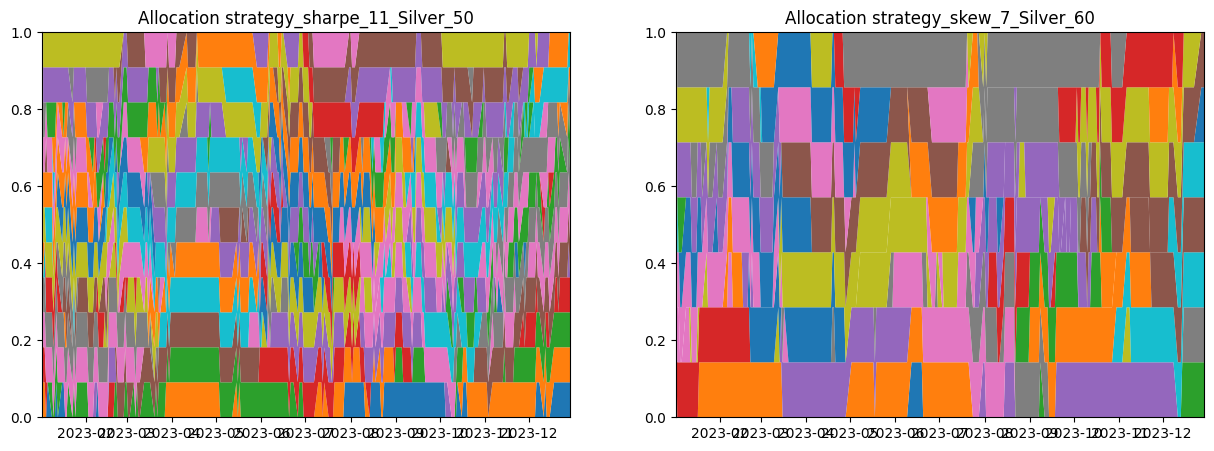

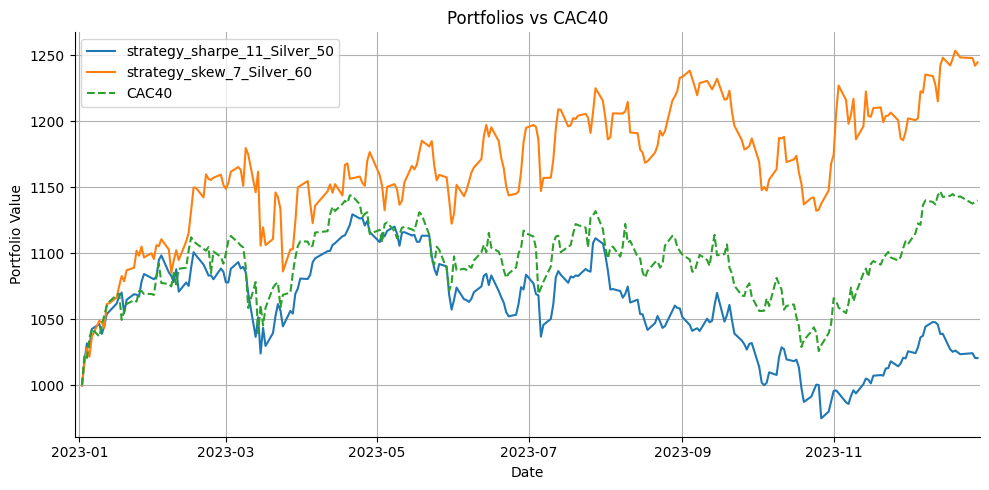

Annualized Return Annualized Volatility  \
2023 strategy_sharpe_11_Silver_50              2.04                 12.38   
     CAC40                                    13.82                 13.74   
     strategy_skew_7_Silver_60                24.13                 16.86   

                                  Sharpe Max Draw-Down  
2023 strategy_sharpe_11_Silver_50   0.16         -14.3  
     CAC40                          1.01        -10.41  
     strategy_skew_7_Silver_60      1.43         -8.83

In [ ]:
strategies = [(strategy_sharpe, 11, 'Silver',50),(strategy_skew, 7, 'Silver',60)]
statistics = backtest_compare('01/01/2023', '01/01/2024', 1000, [1/10] * 39, strategies, 70)
statistics.head(50)